# Programmable illumination: phase contrast

_Srayan Gangopadhyay_  
_Thu 9 Mar 2023_

Sources:
- https://stackoverflow.com/questions/49330080/numpy-2d-array-selecting-indices-in-a-circle
- https://stackoverflow.com/questions/38674027/find-the-row-indexes-of-several-values-in-a-numpy-array

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from skimage import io
from scipy import ndimage
import cv2
from led_posns import *

To do:
- [X] Combine all images into single stack
- [X] Rescale all images
- [X] Find centre LED using max brightness
- [ ] ~~Find rotation using max brightness~~


## Simulating the LED setup to get the required indices

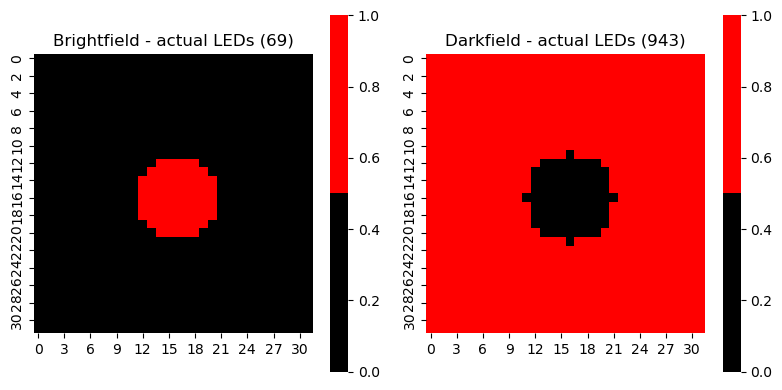

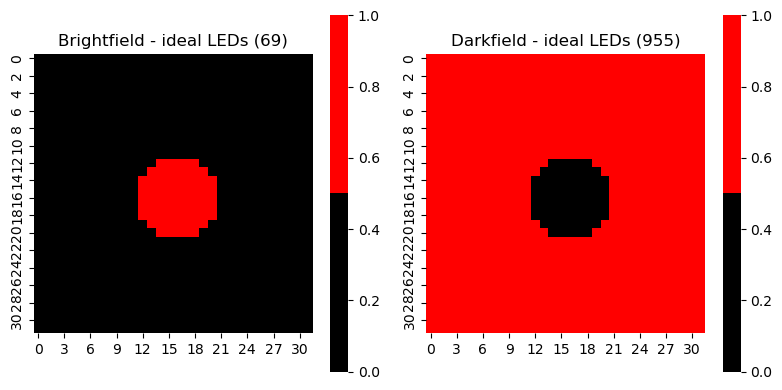

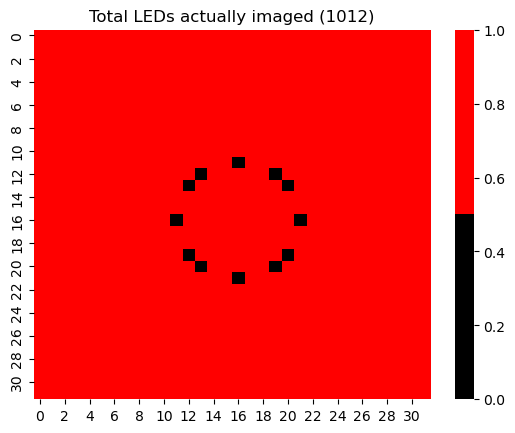

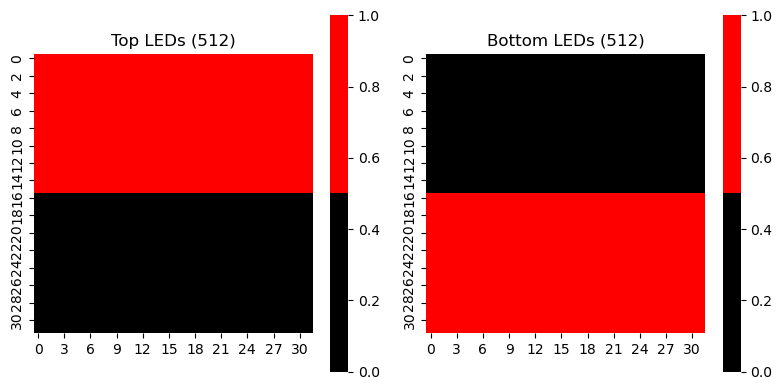

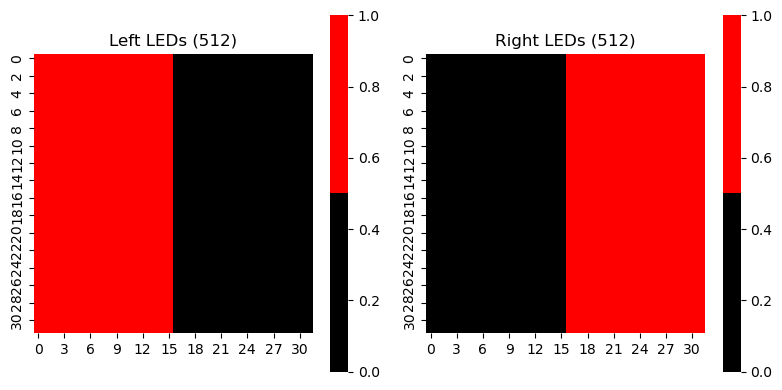

In [3]:
bright_posns, dark_posns, top_posns, bottom_posns, left_posns, right_posns, difference = get_led_posns(32, 5)

## Reading in the images

In [4]:
img_dir = r'D:\MSci_Project\1_Data\2023-03-08\2023-03-08 bead phantom raster'
brightfield = io.imread(img_dir + r'\2023-03-08 bead phantom brightfield raster kept stack.tif')[:-1]
darkfield_1 = io.imread(img_dir + r'\2023-03-08 bead phantom darkfield raster.tiff')
darkfield_2 = io.imread(img_dir + r'\2023-03-08 bead phantom darkfield raster_X1.tif')
darkfield = np.concatenate((darkfield_1, darkfield_2))[:-1]


# note: rescale for exposure time?
print(f'Loaded {brightfield.shape[0]} bright and {darkfield.shape[0]} dark images.')

Loaded 69 bright and 955 dark images.


In [5]:
# combining the brightfield and darkfield images in the right order, skipping LEDs that weren't actually imaged

all_posns = np.transpose(np.where(difference==1))
all_imgs = np.zeros((1012, 1392, 1040))

brights_added = 0
darks_added = 0

for i in range(len(all_posns)):
    if any((bright_posns[:]==all_posns[i]).all(1)):
        all_imgs[i] = brightfield[brights_added]
        brights_added +=1
    if any((dark_posns[:]==all_posns[i]).all(1)):
        all_imgs[i] = darkfield[darks_added]
        darks_added +=1
        
print(f'Combined into stack of {all_imgs.shape[0]}, dimensions {all_imgs.shape[1:]}')
        
# normalise all images - WHY DOESN'T THIS WORK PROPERLY?
for a in all_imgs:
    a = (255*(a - np.min(a))/np.ptp(a)).astype(int)

Combined into stack of 1012, dimensions (1392, 1040)


In [6]:
brights_added + darks_added

1012

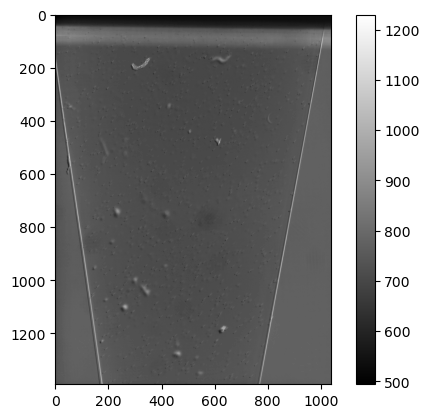

In [7]:
plt.imshow(np.sum(all_imgs, axis=0)/1012, cmap='gray')
plt.colorbar()
plt.show()

In [8]:
# # background subtraction
# bright_bg = np.mean(io.imread(r'D:\MSci_Project\1_Data\2023-03-08\2023-03-08 brightfield 50ms\MMStack_Pos0.ome.tif'), axis=0)
# dark_bg = np.mean(io.imread(r'D:\MSci_Project\1_Data\2023-03-08\2023-03-08 darkfield 200ms\MMStack_Pos0.ome.tif'), axis=0)
# brightfield = np.clip(brightfield - bright_bg, 0, brightfield.max())
# darkfield = np.clip(darkfield - dark_bg, 0, darkfield.max())

## Can we find the central LED from the images?

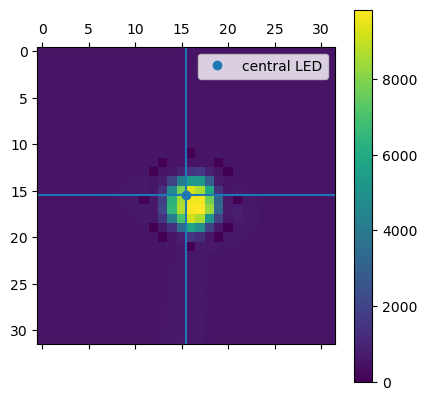

In [9]:
bright_brightnesses = [np.mean(im) for im in brightfield]
dark_brightnesses = [np.mean(im) for im in darkfield]

leds = np.zeros((32, 32))
for i in range(len(bright_posns)):
    coord = bright_posns[i]
    leds[coord[0], coord[1]] = np.mean(brightfield[i])
for i in range(len(dark_posns)):
    coord = dark_posns[i]
    leds[coord[0], coord[1]] = np.mean(darkfield[i])
    
plt.matshow(leds)
plt.plot(15.5, 15.5, 'o', label='central LED')
plt.axhline(y=15.5)
plt.axvline(x=15.5)
plt.legend()
plt.colorbar()
plt.show()

In [10]:
stack = io.imread(r'D:\MSci_Project\1_Data\2023-03-10\2023-03-10 square raster 16 cuvette.tiff')
stack_average = np.average(stack, axis=1)
stack_average = np.average(stack_average, axis=1)
stack_average = np.reshape(stack_average, (16,16))

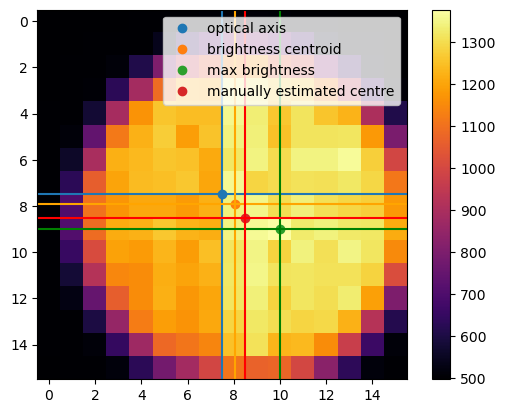

In [11]:
centroid = ndimage.center_of_mass(stack_average)
max_coords = np.unravel_index(stack_average.argmax(), stack_average.shape)
plt.imshow(stack_average, cmap='inferno')
plt.plot(7.5, 7.5, 'o', label='optical axis')
plt.axhline(y=7.5)
plt.axvline(x=7.5)
plt.plot(centroid[1], centroid[0], 'o', label='brightness centroid')
plt.axhline(y=centroid[0], color='orange')
plt.axvline(x=centroid[1], color='orange')
plt.plot(max_coords[1], max_coords[0], 'o', label='max brightness')
plt.axhline(y=max_coords[0], color='green')
plt.axvline(x=max_coords[1], color='green')
plt.plot(8.5, 8.5, 'o', label='manually estimated centre')
plt.axhline(y=8.5, color='red')
plt.axvline(x=8.5, color='red')
plt.colorbar()
plt.legend()
plt.show()

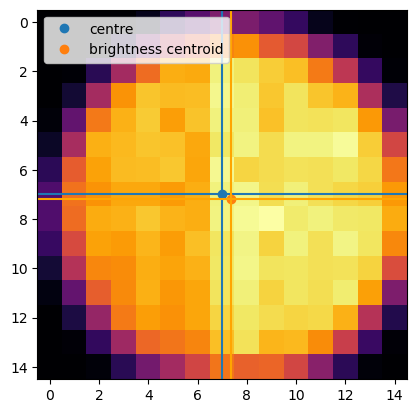

In [12]:
plt.imshow(stack_average[1:, 1:], cmap='inferno')
plt.plot(7, 7, 'o', label='centre')
plt.axhline(y=7)
plt.axvline(x=7)
centroid = ndimage.center_of_mass(stack_average[1:, 1:])
plt.plot(centroid[1], centroid[0], 'o', label='brightness centroid')
plt.axhline(y=centroid[0], color='orange')
plt.axvline(x=centroid[1], color='orange')
plt.legend()
plt.show()

If we crop by one pixel on each side, our array dimensions are now odd (`(15, 15)`) - so how do we split our left-right, top-bottom phase gradient images? Do we reuse the middle rows e.g., split `[0, 1, 2, 3, 4]` into `[0, 1, 2]` and `[2, 3, 4]`?

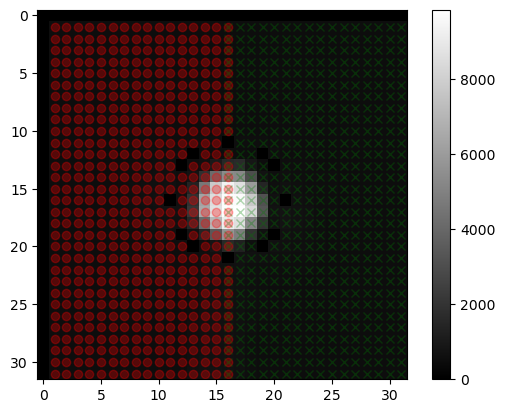

In [13]:
brightnesses = np.zeros((32, 32))

for coord, img in zip(all_posns, all_imgs):
    if coord[0] != 0 and coord[1] != 0:
        brightnesses[coord[0], coord[1]] = np.mean(img)
        if coord[0] <= 16:
            plt.plot(coord[0], coord[1], 'o', color='red', alpha=0.3)
        if coord[0] >= 16:
            plt.plot(coord[0], coord[1], 'x', color='green', alpha=0.3)
    
plt.imshow(brightnesses, cmap='gray')
plt.colorbar()
plt.show()

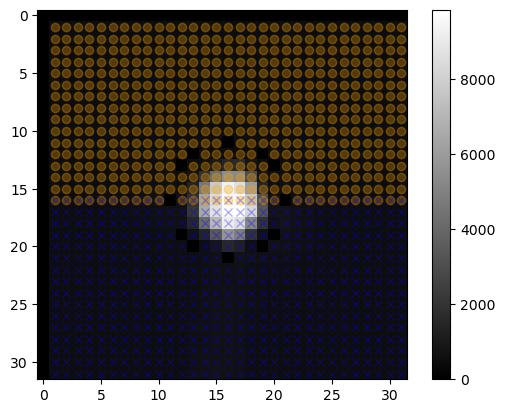

In [14]:
brightnesses = np.zeros((32, 32))

for coord, img in zip(all_posns, all_imgs):
    if coord[0] != 0 and coord[1] != 0:
        brightnesses[coord[0], coord[1]] = np.mean(img)
        if coord[1] <= 16:
            plt.plot(coord[0], coord[1], 'o', color='orange', alpha=0.3)
        if coord[1] >= 16:
            plt.plot(coord[0], coord[1], 'x', color='blue', alpha=0.3)
    
plt.imshow(brightnesses, cmap='gray')
plt.colorbar()
plt.show()

## Corrected phase contrast images

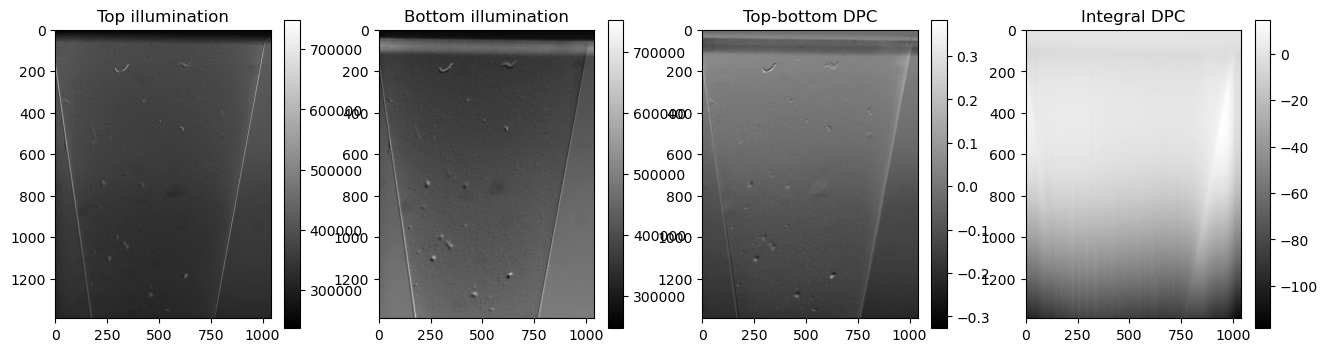

In [25]:
top = np.zeros((1392, 1040))
bottom = np.zeros((1392, 1040))

for coord, img in zip(all_posns, all_imgs):
    if coord[0] != 0 and coord[1] != 0:
        if coord[0] <= 16:
            top += img
        if coord[0] >= 16:
            bottom += img

fig, axs = plt.subplots(1, 4, figsize=(16, 4))

mpbl = axs[0].imshow(top, cmap='gray')
plt.colorbar(mpbl)
axs[0].set_title('Top illumination')
mpbl = axs[1].imshow(bottom, cmap='gray')
plt.colorbar(mpbl)
axs[1].set_title('Bottom illumination')
tb_phsgrd = (top-bottom)/(top+bottom)
mpbl = axs[2].imshow(tb_phsgrd, cmap='gray')
plt.colorbar(mpbl)
axs[2].set_title('Top-bottom DPC')

tb_integral = np.zeros((1391, 1040))
for i in range(tb_phsgrd.shape[0]-1):
    tb_integral[i, :] = np.sum(tb_phsgrd[:i, :], axis=0)

mpbl = axs[3].imshow(tb_integral, cmap='gray')
plt.colorbar(mpbl)
axs[3].set_title('Integral DPC')
plt.show()

In [20]:
tb_phsgrd.shape

(1392, 1040)

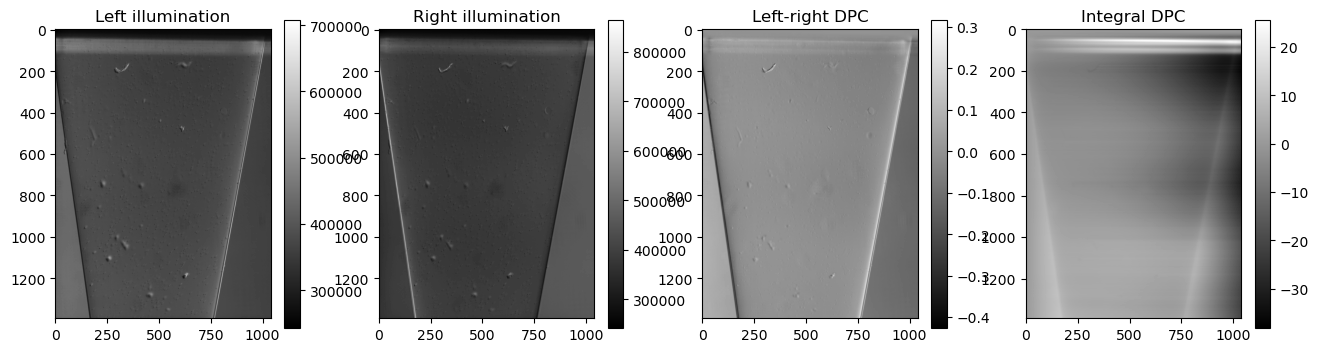

In [28]:
left = np.zeros((1392, 1040))
right = np.zeros((1392, 1040))

for coord, img in zip(all_posns, all_imgs):
    if coord[0] != 0 and coord[1] != 0:
        if coord[1] <= 16:
            left += img
        if coord[1] >= 16:
            right += img

fig, axs = plt.subplots(1, 4, figsize=(16, 4))

mpbl = axs[0].imshow(left, cmap='gray')
plt.colorbar(mpbl)
axs[0].set_title('Left illumination')
mpbl = axs[1].imshow(right, cmap='gray')
plt.colorbar(mpbl)
axs[1].set_title('Right illumination')
lr_phsgrd = (left-right)/(left+right)
mpbl = axs[2].imshow(lr_phsgrd, cmap='gray')
plt.colorbar(mpbl)
axs[2].set_title('Left-right DPC')

lr_integral = np.zeros((1392, 1039))
for i in range(lr_phsgrd.shape[1]-1):
    lr_integral[:, i] = np.sum(lr_phsgrd[:, :i], axis=1)

mpbl = axs[3].imshow(lr_integral, cmap='gray')
plt.colorbar(mpbl)
axs[3].set_title('Integral DPC')
plt.show()

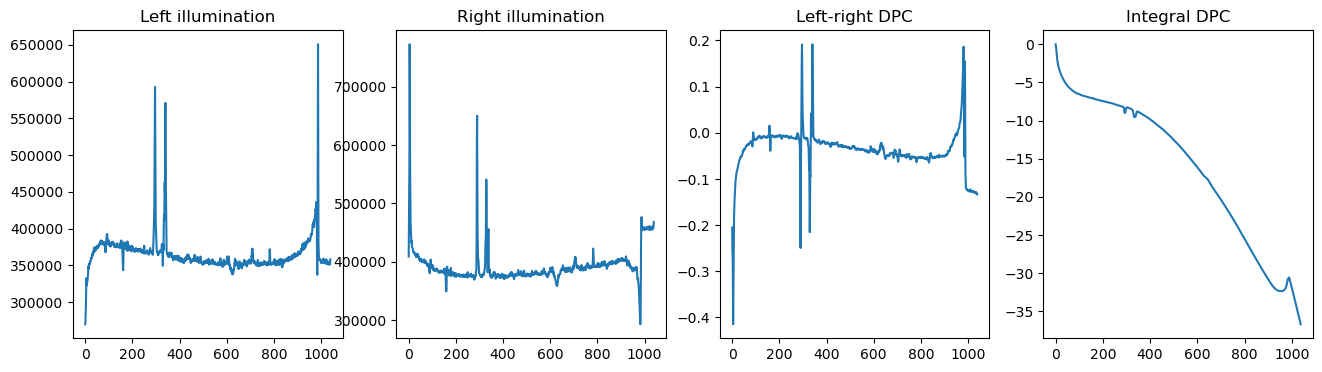

In [29]:
left = np.zeros((1392, 1040))
right = np.zeros((1392, 1040))

for coord, img in zip(all_posns, all_imgs):
    if coord[0] != 0 and coord[1] != 0:
        if coord[1] <= 16:
            left += img
        if coord[1] >= 16:
            right += img

fig, axs = plt.subplots(1, 4, figsize=(16, 4))


axs[0].plot(left[190, :])
axs[0].set_title('Left illumination')
axs[1].plot(right[190, :])
axs[1].set_title('Right illumination')
lr_phsgrd = (left-right)/(left+right)
axs[2].plot(lr_phsgrd[190, :])
axs[2].set_title('Left-right DPC')

lr_integral = np.zeros((1392, 1039))
for i in range(lr_phsgrd.shape[1]-1):
    lr_integral[:, i] = np.sum(lr_phsgrd[:, :i], axis=1)

axs[3].plot(lr_integral[190, :])
axs[3].set_title('Integral DPC')
plt.show()

---

## OLD: Calculating the phase contrast images
_This is prior to the discovery of problems with alignment and missing images._

Assuming $I_{DPC} = \frac{I_L - I_R}{I_L + I_R}$ (from [here](https://doi.org/10.1371/journal.pone.0124938))

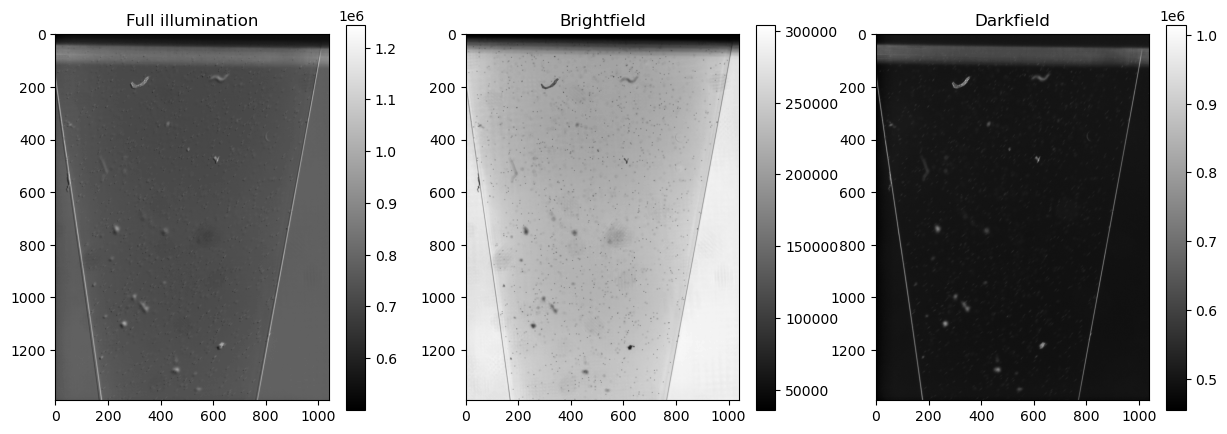

In [11]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

mpbl = axs[0].imshow(np.sum(np.concatenate((brightfield, darkfield)), axis=0), cmap='gray')
plt.colorbar(mpbl)
axs[0].set_title('Full illumination')
mpbl = axs[1].imshow(np.sum(brightfield, axis=0), cmap='gray')
plt.colorbar(mpbl)
axs[1].set_title('Brightfield')
mpbl = axs[2].imshow(np.sum(darkfield, axis=0), cmap='gray')
plt.colorbar(mpbl)
axs[2].set_title('Darkfield')
plt.show()

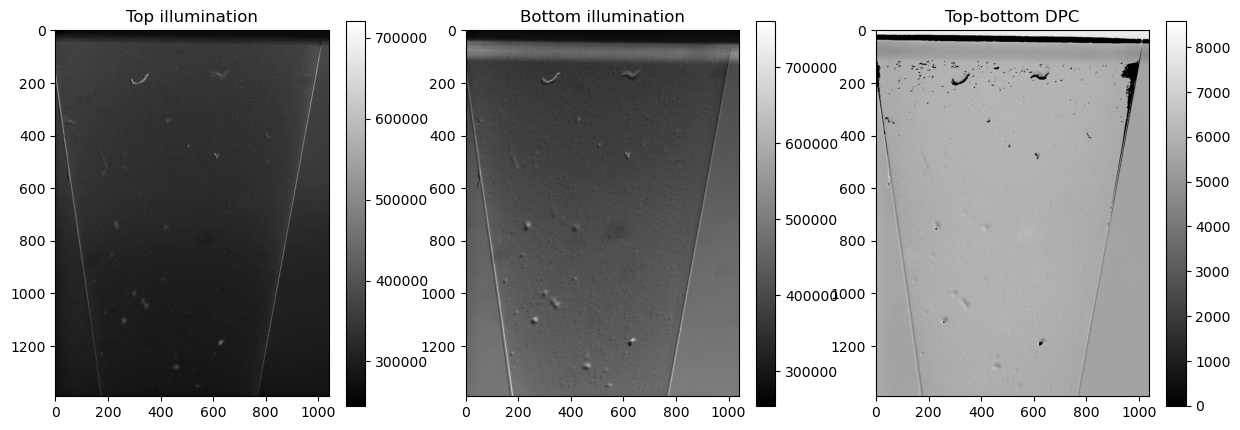

In [12]:
top = np.sum(np.concatenate((brightfield[XinY(top_posns, bright_posns)], darkfield[XinY(top_posns, dark_posns)])), axis=0)
bottom = np.sum(np.concatenate((brightfield[XinY(bottom_posns, bright_posns)], darkfield[XinY(bottom_posns, dark_posns)])), axis=0)

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

mpbl = axs[0].imshow(top, cmap='gray')
plt.colorbar(mpbl)
axs[0].set_title('Top illumination')
mpbl = axs[1].imshow(bottom, cmap='gray')
plt.colorbar(mpbl)
axs[1].set_title('Bottom illumination')
mpbl = axs[2].imshow((top-bottom)/(top+bottom), cmap='gray')
plt.colorbar(mpbl)
axs[2].set_title('Top-bottom DPC')
plt.show()

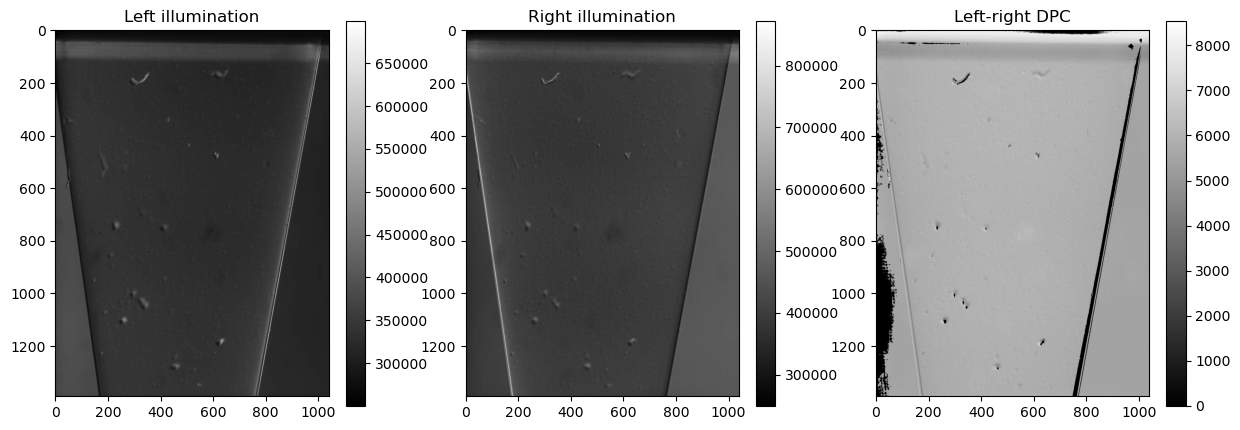

In [13]:
left = np.sum(np.concatenate((brightfield[XinY(left_posns, bright_posns)], darkfield[XinY(left_posns, dark_posns)])), axis=0)
right = np.sum(np.concatenate((brightfield[XinY(right_posns, bright_posns)], darkfield[XinY(right_posns, dark_posns)])), axis=0)

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

mpbl = axs[0].imshow(left, cmap='gray')
plt.colorbar(mpbl)
axs[0].set_title('Left illumination')
mpbl = axs[1].imshow(right, cmap='gray')
plt.colorbar(mpbl)
axs[1].set_title('Right illumination')
mpbl = axs[2].imshow((left-right)/(left+right), cmap='gray')
plt.colorbar(mpbl)
axs[2].set_title('Left-right DPC')
plt.show()

## Digital refocusing

$I^{\Delta Z} = \Sigma I_i(x + \Delta z \tan{\theta_x}, y + \Delta z \tan{\theta_y})$, where $\tan{\theta_x} = \frac{\Delta x}{L} = \frac{(16-i) \times 4 mm}{L}$ and $\tan{\theta_y} = \frac{(j-16) \times 4 mm}{L}$, if we define x upwards and y to the right of the central LED (since (0,0) is top-left). 

TODO: measure L  
NOTE: effect of water on k-vector?

In [99]:
def shift_image(image, x_shift_mm, y_shift_mm):
    """
    Return translated image, given x and y shifts in mm,
    assuming a pixel size of 6.45um
    """
    x_shift_px = x_shift_mm / 6.45e-3
    y_shift_px = y_shift_mm / 6.45e-3
    
    M = np.float32([
        [1, 0, x_shift_px],
        [0, 1, y_shift_px]
    ])
    
    return cv2.warpAffine(image, M, (image.shape[1], image.shape[0]))


def required_shifts(i, j, delta_z, L=355):
    """
    Calculated required shifts in mm given LED coordinates
    and required refocus distance delta_z, assuming a 32x32
    LED array with pitch 4mm, with LED (16, 16) centred on 
    the optical axis, and with (0, 0) at the top left.
    """
    delta_x = (16-i) * 4
    tan_theta_x = delta_x / L
    x_shift_mm = delta_z * tan_theta_x
    
    delta_y = (j-16) * 4
    tan_theta_y = delta_y / L
    y_shift_mm = delta_z * tan_theta_y
    
    
    return x_shift_mm, y_shift_mm


def refocus_img(all_posns, all_imgs, delta_z):
    refocused = np.zeros((all_imgs.shape[1], all_imgs.shape[2]))
    for coord, img in zip(all_posns, all_imgs):
        x_shift_mm, y_shift_mm = required_shifts(coord[0], coord[1], delta_z)
        refocused += shift_image(img, x_shift_mm, y_shift_mm)
    return refocused

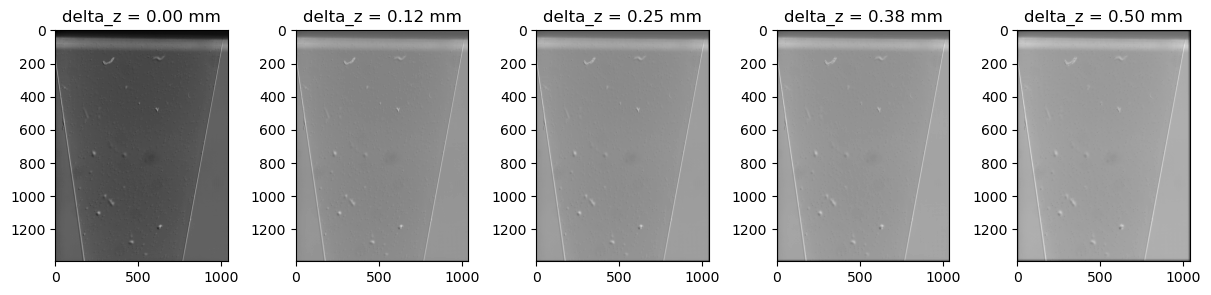

In [100]:
fig, axs = plt.subplots(1, 5, figsize=(15, 3))
for i, shift in zip(range(5), np.linspace(0, 0.5, 5)):
    axs[i].imshow(refocus_img(all_posns, all_imgs, shift), cmap='gray')
    axs[i].set_title(f'delta_z = {shift:.2f} mm')